Old Random Forest notebook with notes in it 

In [3]:
# Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (train_test_split, 
                                     RandomizedSearchCV, 
                                     cross_val_score,
                                     RepeatedStratifiedKFold
                                    )
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from scipy import stats
from sklearn.ensemble import (RandomForestRegressor, 
                              RandomForestClassifier
                             )
from sklearn.metrics import (accuracy_score, 
                             confusion_matrix, 
                             precision_score, 
                             recall_score, 
                             #roc_auc_score, 
                             #roc_curve, 
                             f1_score
                            )
from sklearn.preprocessing import (OneHotEncoder, 
                                   OrdinalEncoder
                                  )
from sklearn.compose import make_column_transformer
from pprint import pprint
from sklearn.pipeline import make_pipeline
from numpy import (mean, 
                   std
                  )
#from numpy import std
from sklearn.datasets import make_classification
from sklearn.tree import export_graphviz
from functions import hello_world

# set display options
pd.set_option('display.max_columns', None)
%matplotlib inline

ImportError: cannot import name 'hello_world' from 'functions' (/Users/paulsprouse/OneDrive/NYDS/ames_data/ames_data_project/functions/__init__.py)

In [4]:
hello_world()

#


NameError: name 'hello_world' is not defined

In [47]:
# using the data_load function to get the data as I need it for this part of the project
train_x, train_y = data_load()

In [55]:
# Finding the Neighborhoods with the highest number of counts
# will take top 3 neighborhoods and will do all neighborhoods including top 3
train_x.groupby('Neighborhood')['OverallCond'].count().sort_values(ascending=False).head(15).reset_index()

,Neighborhood,OverallCond
0,NAmes,225
1,CollgCr,150
2,OldTown,113
3,Edwards,100
4,Somerst,86
5,Gilbert,79
6,NridgHt,77
7,Sawyer,74
8,NWAmes,73
9,SawyerW,59


In [60]:
# looking at the number of unique values per category

pd.DataFrame.from_records([(col, train_x[col].nunique()) for col in train_x.columns],
                          columns=['Column', 'Num_Unique']).sort_values(by=['Num_Unique'])

,Column,Num_Unique
13,ExterCond,1
39,MiscVal,1
20,2ndFlrSF,2
11,MasVnrArea,2
18,CentralAir,2
2,LotShape,2
24,BedroomAbvGr,3
36,OpenPorchSF,3
23,HalfBath,3
26,KitchenQual,3


In [96]:
# setup classifier these parameters were created from numerous runs on the full data set
# for testing set true, else false for full run
quick_ = True
if quick_:
    val_ = [1000, 2]
    num_ = 10
else:
    val_ = [2500, 4]
    num_ = 20
    rf_classifier = RandomForestClassifier(
                      min_samples_leaf=3,
                      n_estimators=val_[0],
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=22,
                      max_features=val_[1])

In [97]:
'''making copy of the train_x data so I don't change it during this process - also adding
the saleprice back in so that when I group data it will all be matched'''

train_xy=train_x.copy()
train_xy['SalePrice'] =train_y
train_xy

,MSZoning,LotArea,LotShape,LandContour,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,Heating,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,OpenPorchSF,Fence,MiscFeature,MiscVal,MoSold,YrSold,SalePrice
0,RL,"(7553.5, 9478.5]",1,Lvl,CollgCr,1Fam,2Story,4,2,"(2000.0, 2010.0]",BrkFace,"(164.25, 1600.0]",Gd,0,PConc,3,2,GasA,Y,"(333.999, 882.0]","(728.0, 2065.0]","(1464.0, 1776.75]",2,1,2,1,3,3,0,0,Attchd,RFn,2,2,2,Y,"(25.0, 68.0]",NA,NA,"(-0.001, 15500.0]",2,2008,"(183333.333, 262500.0]"
1,RL,"(9478.5, 11601.5]",1,Lvl,Veenker,1Fam,1Story,3,4,"(1973.0, 2000.0]",None,"(-0.001, 164.25]",TA,0,CBlock,3,2,GasA,Y,"(1087.0, 1391.25]","(-0.001, 728.0]","(1129.5, 1464.0]",2,0,2,1,2,2,1,2,Attchd,RFn,2,2,2,Y,"(-0.001, 25.0]",NA,NA,"(-0.001, 15500.0]",5,2007,"(104166.667, 183333.333]"
2,RL,"(9478.5, 11601.5]",0,Lvl,CollgCr,1Fam,2Story,4,2,"(2000.0, 2010.0]",BrkFace,"(-0.001, 164.25]",Gd,0,PConc,3,2,GasA,Y,"(882.0, 1087.0]","(728.0, 2065.0]","(1776.75, 5642.0]",2,1,2,1,3,2,1,2,Attchd,RFn,2,2,2,Y,"(25.0, 68.0]",NA,NA,"(-0.001, 15500.0]",9,2008,"(183333.333, 262500.0]"
3,RL,"(9478.5, 11601.5]",0,Lvl,Crawfor,1Fam,2Story,4,2,"(1871.999, 1954.0]",None,"(-0.001, 164.25]",TA,0,BrkTil,2,3,GasA,Y,"(882.0, 1087.0]","(728.0, 2065.0]","(1464.0, 1776.75]",1,0,2,1,3,3,1,3,Detchd,Unf,3,2,2,Y,"(25.0, 68.0]",NA,NA,"(-0.001, 15500.0]",2,2006,"(104166.667, 183333.333]"
4,RL,"(11601.5, 215245.0]",0,Lvl,NoRidge,1Fam,2Story,4,2,"(1973.0, 2000.0]",BrkFace,"(164.25, 1600.0]",Gd,0,PConc,3,2,GasA,Y,"(1087.0, 1391.25]","(728.0, 2065.0]","(1776.75, 5642.0]",2,1,2,1,3,3,1,2,Attchd,RFn,3,2,2,Y,"(68.0, 547.0]",NA,NA,"(-0.001, 15500.0]",12,2008,"(183333.333, 262500.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,"(7553.5, 9478.5]",1,Lvl,Gilbert,1Fam,2Story,3,2,"(1973.0, 2000.0]",None,"(-0.001, 164.25]",TA,0,PConc,3,2,GasA,Y,"(882.0, 1087.0]","(-0.001, 728.0]","(1464.0, 1776.75]",2,1,2,1,2,3,1,2,Attchd,RFn,2,2,2,Y,"(25.0, 68.0]",NA,NA,"(-0.001, 15500.0]",8,2007,"(104166.667, 183333.333]"
1456,RL,"(11601.5, 215245.0]",1,Lvl,NWAmes,1Fam,1Story,3,3,"(1973.0, 2000.0]",Stone,"(-0.001, 164.25]",TA,0,CBlock,3,2,GasA,Y,"(1391.25, 4692.0]","(-0.001, 728.0]","(1776.75, 5642.0]",2,0,2,1,2,3,2,2,Attchd,Unf,2,2,2,Y,"(-0.001, 25.0]",MnPrv,NA,"(-0.001, 15500.0]",2,2010,"(183333.333, 262500.0]"
1457,RL,"(7553.5, 9478.5]",1,Lvl,Crawfor,1Fam,2Story,4,5,"(1871.999, 1954.0]",None,"(-0.001, 164.25]",Ex,0,Stone,2,3,GasA,Y,"(1087.0, 1391.25]","(728.0, 2065.0]","(1776.75, 5642.0]",2,0,2,1,3,3,2,3,Attchd,RFn,1,2,2,Y,"(25.0, 68.0]",GdPrv,Shed,"(-0.001, 15500.0]",5,2010,"(262500.0, 341666.667]"
1458,RL,"(9478.5, 11601.5]",1,Lvl,NAmes,1Fam,1Story,2,3,"(1871.999, 1954.0]",None,"(-0.001, 164.25]",TA,0,CBlock,2,2,GasA,Y,"(882.0, 1087.0]","(-0.001, 728.0]","(333.999, 1129.5]",1,0,1,1,3,2,0,0,Attchd,Unf,1,2,2,Y,"(-0.001, 25.0]",NA,NA,"(-0.001, 15500.0]",4,2010,"(104166.667, 183333.333]"


In [98]:
def top_feature_plot(feature_imp_ranked_, num=20):    
    feature_names_ = [i[0] for i in feature_imp_ranked_[:num]]
    y_ticks = np.arange(0, len(feature_names_))
    x_axis = [i[1] for i in feature_imp_ranked_[:num]]
    plt.figure(figsize = (10, 14))
    plt.barh(feature_names_, x_axis)   #horizontal barplot
    plt.title('Random Forest Feature Importance',
              fontdict= {'fontname':'Comic Sans MS','fontsize' : 20})
    plt.xlabel('Features',fontdict= {'fontsize' : 16})
    plt.show()

In [99]:
def feature_imp_lst(enc_, imp_, num=num_):
    feature_importances_ = list(zip(enc_, imp_))    
# sort the feature importances by most important first
    feature_importances_ranked_ = sorted(feature_importances_, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
    [print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked_[:num]]; 
    return feature_importances_ranked_

    

In [100]:
def sum_dict(dict_):
    return {k: sum(v) for k,v in dict_.items()}

def sort_dict(dict_):
    return {k: dict_[k] for k in sorted(dict_, key=dict_.get, reverse=True)}

NAmes


/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


 There are 148 features in total
Feature: Heating_GasW                        Importance: 0.05493098704935705
Feature: Heating_OthW                        Importance: 0.03918968580549752
Feature: HouseStyle_SFoyer                   Importance: 0.03846669672459213
Feature: Heating_Wall                        Importance: 0.03618296769763749
Feature: BsmtCond_3                          Importance: 0.026386118943655064
Feature: LotArea_(11601.5, 215245.0]         Importance: 0.024812861315292888
Feature: BsmtCond_2                          Importance: 0.024082768724849265
Feature: ExterQual_Ex                        Importance: 0.02389793975833815
Feature: TotRmsAbvGrd_2                      Importance: 0.0237334767500047
Feature: FullBath_1                          Importance: 0.023370818040580336


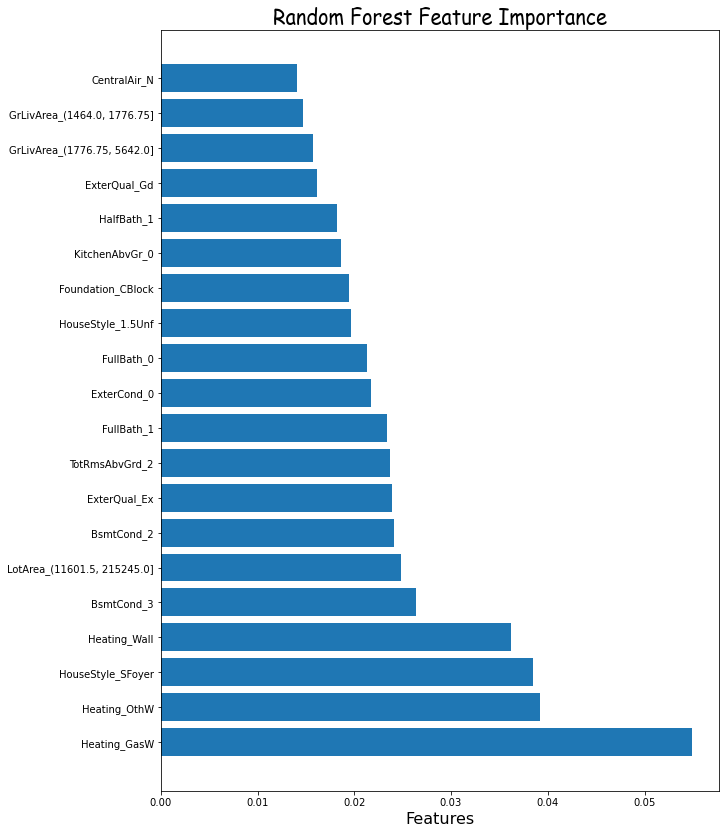

CollgCr


/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


 There are 120 features in total
Feature: Foundation_Slab                     Importance: 0.06235394110986517
Feature: Foundation_Wood                     Importance: 0.06108142230495305
Feature: Foundation_Stone                    Importance: 0.05930176422431628
Feature: HouseStyle_2.5Fin                   Importance: 0.05475214257745036
Feature: KitchenAbvGr_2                      Importance: 0.04873845054782645
Feature: HouseStyle_1.5Unf                   Importance: 0.03646858399714897
Feature: BsmtCond_3                          Importance: 0.034711227176481424
Feature: BsmtCond_2                          Importance: 0.030910823815506163
Feature: GrLivArea_(333.999, 1129.5]         Importance: 0.020731065682453583
Feature: FullBath_0                          Importance: 0.020611621179529766


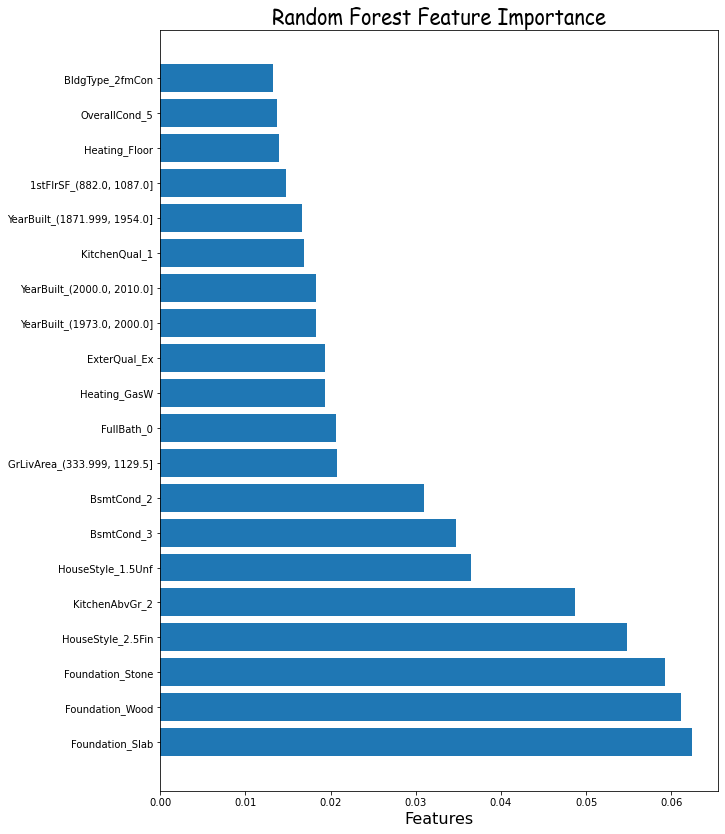

OldTown


/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


 There are 151 features in total
Feature: GarageType_CarPort                  Importance: 0.03042838180369166
Feature: HouseStyle_2.5Unf                   Importance: 0.025344311466977826
Feature: TotRmsAbvGrd_4                      Importance: 0.02190503020978712
Feature: HalfBath_1                          Importance: 0.021707795636188278
Feature: OverallQual_4                       Importance: 0.019326886743943287
Feature: GarageFinish_NA                     Importance: 0.01900123263475478
Feature: LandContour_Bnk                     Importance: 0.018150323122288186
Feature: FireplaceQu_1                       Importance: 0.01778745388583893
Feature: CentralAir_Y                        Importance: 0.01763461460558794
Feature: OverallQual_2                       Importance: 0.0163529697264621


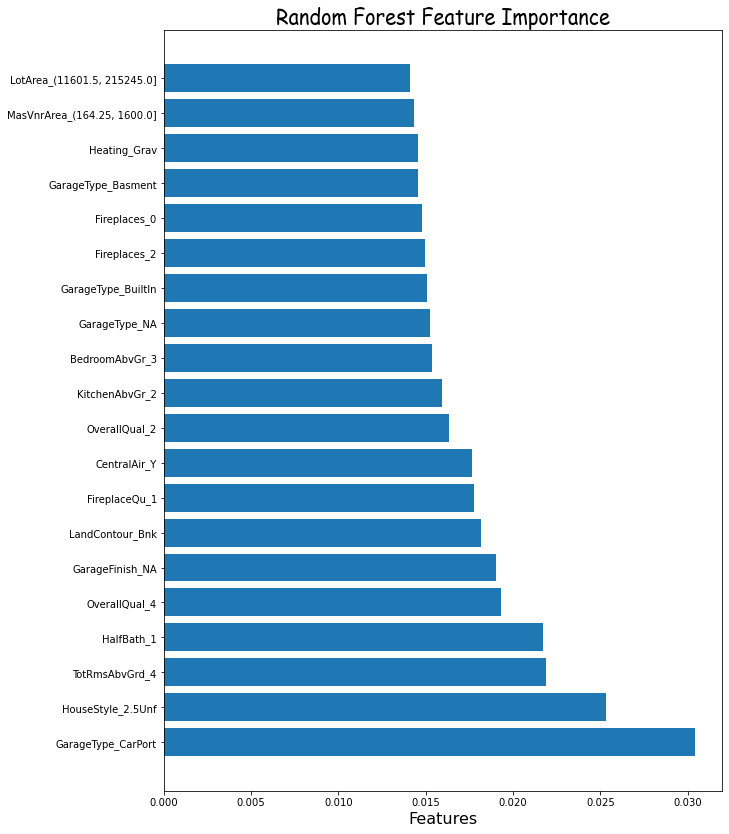

ALL


/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


 There are 168 features in total
Feature: OverallQual_4                       Importance: 0.03982270577530692
Feature: ExterQual_TA                        Importance: 0.031217143317896694
Feature: KitchenQual_3                       Importance: 0.02907169014320406
Feature: ExterQual_Gd                        Importance: 0.028502416098307677
Feature: GrLivArea_(1776.75, 5642.0]         Importance: 0.02849562636937474
Feature: FullBath_1                          Importance: 0.026423155933132193
Feature: KitchenQual_2                       Importance: 0.02542562939761321
Feature: FullBath_2                          Importance: 0.02346753321689864
Feature: OverallQual_2                       Importance: 0.019774367304770755
Feature: BsmtQual_3                          Importance: 0.01958235566336832


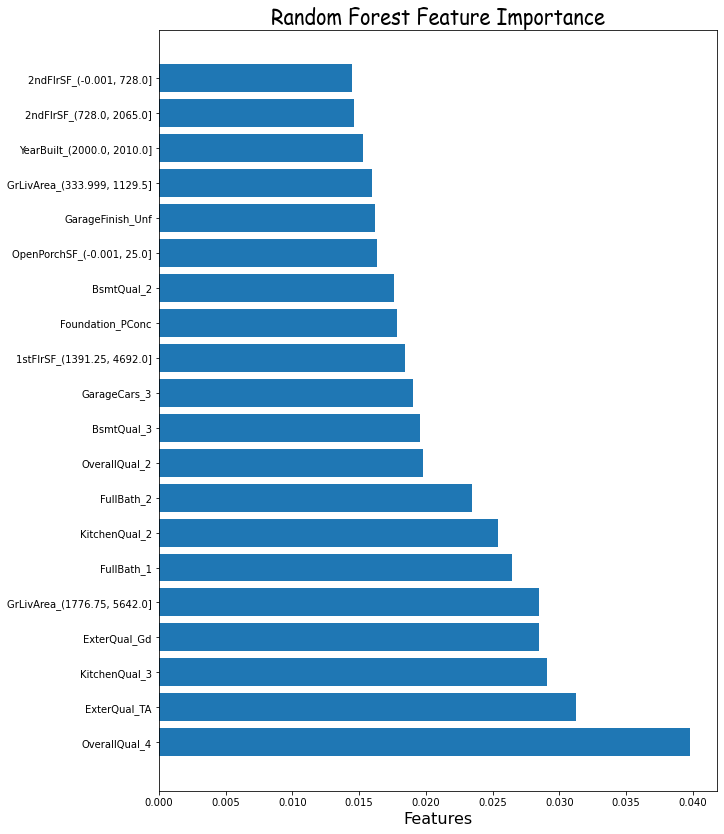

In [101]:
# declare dictionare that gets created of features
cat_t={}

top_ = ['NAmes', 'CollgCr', 'OldTown', 'ALL']#, 'Edwards', 'Somerst']
top_dicts = []
for name in top_:
    print(name)
    if name == 'ALL':
        name_ = train_xy
    else:
        name_ = train_xy.loc[train_xy['Neighborhood'] == name].reset_index(drop=True)
    # why I drop the Nieghborhood? it's because so much of the other variables are baked
    # into the neighborhood, that it overfits the data too easily (other option would be to
    # drop other related columns or decrease the weight -)
    t_x = name_.iloc[:,1:].drop(['Neighborhood', 'SalePrice'], axis=1)
    t_y = name_.iloc[:,-1:]
    col_trans = make_column_transformer(
                        (OneHotEncoder(),t_x.columns.tolist()),
                        remainder = "passthrough"
                        )
    pipe = make_pipeline(col_trans, rf_classifier)
    pipe.fit(t_x, t_y)
    print(f" There are {len(rf_classifier.feature_importances_)} features in total")
    X_t_encoded = encode_and_bind(t_x, t_x.columns.tolist())
    feature_importances_ranked_ = feature_imp_lst(X_t_encoded, rf_classifier.feature_importances_)
    top_feature_plot(feature_importances_ranked_, 20)
    
    
# Dictionary of Features and importances greater than .0001
# cat_ dict is all results top_five_dicts is list of dictionaries by neighborhood
    cat_new = {}
    for feat in feature_importances_ranked_[:20]:     
        if feat[1] > 0.0001:
            cat_t.setdefault(feat[0].split(sep='_')[0], []).append(feat[1])
            cat_new.setdefault(feat[0].split(sep='_')[0], []).append(feat[1])
    top_dicts.append(cat_new)

In [95]:
sort_dict(cat_new)

{'OverallQual': [0.03982270577530692, 0.019774367304770755],
 'ExterQual': [0.031217143317896694, 0.028502416098307677],
 'KitchenQual': [0.02907169014320406, 0.02542562939761321],
 'GrLivArea': [0.02849562636937474, 0.015975211839518014],
 'FullBath': [0.026423155933132193, 0.02346753321689864],
 'BsmtQual': [0.01958235566336832, 0.017648423763748023],
 'GarageCars': [0.01900047978713831],
 '1stFlrSF': [0.01846255338115159],
 'Foundation': [0.01784749215814218],
 'OpenPorchSF': [0.016356355781780626],
 'GarageFinish': [0.016171152906308797],
 'YearBuilt': [0.015312591333700885],
 '2ndFlrSF': [0.01459074666869324, 0.01446706293580829]}

In [102]:
for val in top_dicts:
    print(val)
    print('*'*100)
    print(sum_dict(val))
    print('*'*100)

{'Heating': [0.05493098704935705, 0.03918968580549752, 0.03618296769763749], 'HouseStyle': [0.03846669672459213, 0.0196591106502212], 'BsmtCond': [0.026386118943655064, 0.024082768724849265], 'LotArea': [0.024812861315292888], 'ExterQual': [0.02389793975833815, 0.01612411030623301], 'TotRmsAbvGrd': [0.0237334767500047], 'FullBath': [0.023370818040580336, 0.02128691597579755], 'ExterCond': [0.02169099538077537], 'Foundation': [0.019488281320956872], 'KitchenAbvGr': [0.018656906062499087], 'HalfBath': [0.018255445786259247], 'GrLivArea': [0.015751912492896106, 0.014674884611953926], 'CentralAir': [0.014117983458560317]}
****************************************************************************************************
{'Heating': 0.13030364055249205, 'HouseStyle': 0.058125807374813335, 'BsmtCond': 0.050468887668504325, 'LotArea': 0.024812861315292888, 'ExterQual': 0.04002205006457116, 'TotRmsAbvGrd': 0.0237334767500047, 'FullBath': 0.04465773401637789, 'ExterCond': 0.02169099538077537, 

In [822]:
col_trans = make_column_transformer(
                        (OneHotEncoder(),train_x.columns.tolist()),
                        remainder = "passthrough"
                        )
pipe = make_pipeline(col_trans, rf_classifier)
pipe.fit(train_x, train_y)

print(f" There are {len(rf_classifier.feature_importances_)} features in total")


X_train_encoded = encode_and_bind(train_x, train_x.columns.tolist())


feature_importances = list(zip(X_train_encoded, rf_classifier.feature_importances_))


# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];
cat_all = {}
for feat in feature_importances_ranked_:     
    if feat[1] > 0.0001:
        cat_all.setdefault(feat[0].split(sep='_')[0], []).append(feat[1])

 There are 198 features in total
Feature: OverallQual_4                       Importance: 0.034134416311715
Feature: ExterQual_TA                        Importance: 0.03217170217500622
Feature: KitchenQual_2                       Importance: 0.025874155934578914
Feature: ExterQual_Gd                        Importance: 0.02570267100482753
Feature: GrLivArea_(1776.75, 5642.0]         Importance: 0.02548739301543786
Feature: KitchenQual_3                       Importance: 0.02418662055340745
Feature: FullBath_1                          Importance: 0.023669408487125464
Feature: FullBath_2                          Importance: 0.02364006158542335
Feature: BsmtQual_3                          Importance: 0.020375450598379096
Feature: OverallQual_2                       Importance: 0.017941183594503914
Feature: BsmtQual_2                          Importance: 0.01788278065018895
Feature: 1stFlrSF_(1391.25, 4692.0]          Importance: 0.01738327868241673
Feature: GarageFinish_Unf                

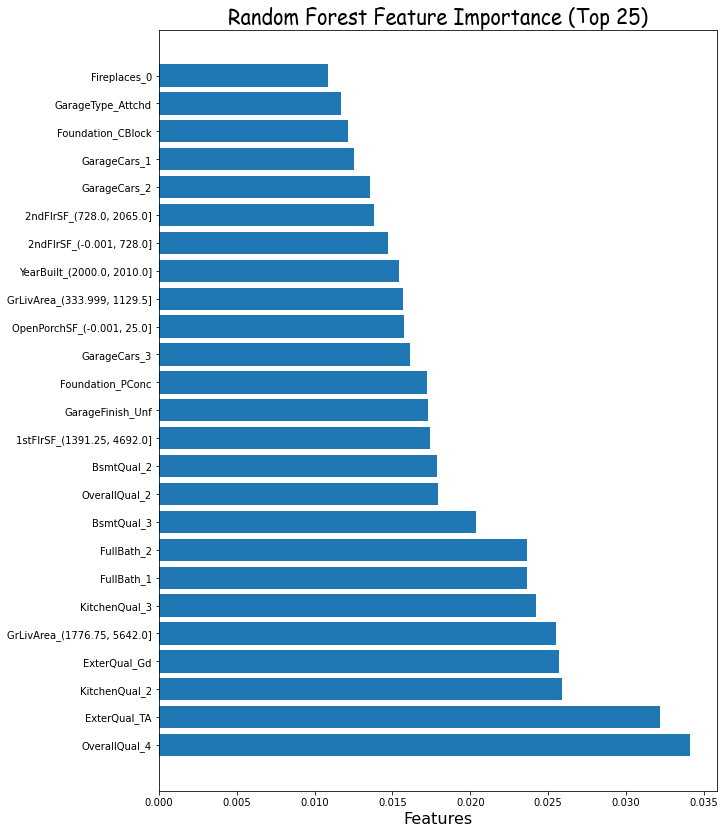

In [823]:

feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:25]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_25, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance (Top 25)',
          fontdict= {'fontname':'Comic Sans MS','fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

In [842]:
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 1500, num = 3)]
max_features = [.2, 5]#, 'log2']  # Number of features to consider at every split
max_depth = [2,4]#[int(x) for x in np.linspace(2, 5, num = 3)]   # Maximum number of levels in tree
#max_depth.append(None)
min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
min_samples_leaf = [1, 10, 15]    # Minimum number of samples required at each leaf node
bootstrap = [True]                # Method of selecting samples for training each tree
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': [None] + list(np.linspace(15, 60, 4).astype(int)),
               'bootstrap': bootstrap}

rf = RandomForestClassifier(oob_score=True, n_jobs=-1)
rf_random = RandomizedSearchCV(
                estimator = rf,
                param_distributions = random_grid,
                n_iter = 150, cv = 3,
                verbose=1, random_state=22,
                scoring='accuracy')

SyntaxError: invalid syntax (<ipython-input-842-ede6315b1ff9>, line 12)

In [825]:
pipe_random = make_pipeline(col_trans, rf_random)
pipe_random.fit(train_x, train_y)
rf_random.best_params_

Fitting 4 folds for each of 150 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 20.4min finished


{'n_estimators': 1700,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 36,
 'max_features': 0.2,
 'max_depth': 4,
 'bootstrap': True}

In [829]:

best_params_lst = []
pipe_best_model_lst = []
top_five = ['NAmes', 'CollgCr']#, 'OldTown', 'Edwards', 'Somerst']
top_five_dicts = []
for name in top_five:
    print(name)
    name_ = train_xy.loc[train_xy['Neighborhood'] == name].reset_index(drop=True)
    t_x = name_.iloc[:,1:]
    t_y = name_.iloc[:,-1:]
    col_trans = make_column_transformer(
                        (OneHotEncoder(),t_x.columns.tolist()),
                        remainder = "passthrough"
                        )
    pipe_random = make_pipeline(col_trans, rf_random)
    pipe_random.fit(t_x, t_y)
    rf_random.best_params_
    best_params_lst.append(rf_random.best_params_)
    pipe_best_model_lst.append(pipe_random)

NAmes
Fitting 4 folds for each of 150 candidates, totalling 600 fits


/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

CollgCr
Fitting 4 folds for each of 150 candidates, totalling 600 fits


/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

In [841]:
pipe_best_model_lst[0].fit(t_x,t_y)

Fitting 4 folds for each of 150 candidates, totalling 600 fits


/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_s

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['LotArea', 'LotShape',
                                                   'LandContour',
                                                   'Neighborhood', 'BldgType',
                                                   'HouseStyle', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'MasVnrType', 'MasVnrArea',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'Heating',
                                                   'CentralAir', '...
             

In [843]:
pipe_best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['LotArea', 'LotShape',
                                                   'LandContour',
                                                   'Neighborhood', 'BldgType',
                                                   'HouseStyle', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'MasVnrType', 'MasVnrArea',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'Heating',
                                                   'CentralAir', '1stFlrSF',
      

In [831]:
# To look at nodes and depths of trees use on average
n_nodes = []
max_depths = []
est_ = []



best_model = rf_random.best_estimator_
pipe_best_model = make_pipeline(col_trans, best_model)
pipe_best_model.fit(train_x, train_y)
#y_pred_best_model = pipe_best_model.predict(train_x)

ValueError: A given column is not a column of the dataframe

In [888]:
# how to reshape the data to fit
np.array(t_y)[:, None].reshape(-1,1)

array([['(183333.333, 262500.0]'],
       ['(183333.333, 262500.0]'],
       ['(262500.0, 341666.667]'],
       ['(183333.333, 262500.0]'],
       ['(104166.667, 183333.333]'],
       ['(104166.667, 183333.333]'],
       ['(104166.667, 183333.333]'],
       ['(183333.333, 262500.0]'],
       ['(104166.667, 183333.333]'],
       ['(183333.333, 262500.0]'],
       ['(183333.333, 262500.0]'],
       ['(104166.667, 183333.333]'],
       ['(183333.333, 262500.0]'],
       ['(183333.333, 262500.0]'],
       ['(183333.333, 262500.0]'],
       ['(341666.667, 420833.333]'],
       ['(104166.667, 183333.333]'],
       ['(183333.333, 262500.0]'],
       ['(183333.333, 262500.0]'],
       ['(183333.333, 262500.0]'],
       ['(183333.333, 262500.0]'],
       ['(104166.667, 183333.333]'],
       ['(183333.333, 262500.0]'],
       ['(104166.667, 183333.333]'],
       ['(104166.667, 183333.333]'],
       ['(104166.667, 183333.333]'],
       ['(104166.667, 183333.333]'],
       ['(183333.333, 262500.0]

In [889]:
pipe_best_model.score(t_x,(np.array(t_y)[:, None].reshape(-1,1)))#train_x, train_y)
#pipe_best_model.oob_score(train_x, train_y)
#ind_tree.tree_.value.shape

/Users/paulsprouse/opt/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


0.9866666666666667

In [890]:
for ind_tree in best_model.estimators_:
       n_nodes.append(ind_tree.tree_.node_count)
       max_depths.append(ind_tree.tree_.max_depth)
       est_.append(ind_tree.score)
       
print(f'Average number of nodes {int(np.mean(n_nodes))}')   
print(f'Average maximum depth {int(np.mean(max_depths))}')


Average number of nodes 10
Average maximum depth 3


In [891]:
ind_tree.score

<bound method ClassifierMixin.score of DecisionTreeClassifier(max_depth=4, max_features=0.2, max_leaf_nodes=14,
                       min_samples_leaf=4, min_samples_split=10,
                       random_state=1910379375)>

In [892]:
best_model.oob_score_

0.9866666666666667

In [893]:
ind_tree.tree_.node_count

9

In [894]:
est_limited = best_model.estimators_[73]

In [908]:
X_train_encoded_ = encode_and_bind(t_x, t_x.columns.tolist())

In [910]:
export_graphviz(est_limited, out_file='tree.dot', feature_names= X_train_encoded_,#X_train_encoded.columns,
                class_names = t_y, rounded = True, proportion = False,
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', 'Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

ValueError: Length of feature_names, 150 does not match number of features, 126

In [765]:
for i, v in enumerate(test_x.columns):
    print(i, v)

0 MSZoning
1 LotArea
2 LotShape
3 LandContour
4 LandSlope
5 Neighborhood
6 BldgType
7 HouseStyle
8 OverallQual
9 OverallCond
10 YearBuilt
11 MasVnrType
12 MasVnrArea
13 ExterQual
14 ExterCond
15 Foundation
16 BsmtQual
17 BsmtCond
18 Heating
19 CentralAir
20 1stFlrSF
21 2ndFlrSF
22 GrLivArea
23 FullBath
24 HalfBath
25 BedroomAbvGr
26 KitchenAbvGr
27 KitchenQual
28 TotRmsAbvGrd
29 Fireplaces
30 FireplaceQu
31 GarageType
32 GarageFinish
33 GarageCars
34 GarageQual
35 GarageCond
36 PavedDrive
37 OpenPorchSF
38 Fence
39 MiscFeature
40 MiscVal
41 MoSold
42 YrSold


In [766]:
train_rf_predictions = pipe_best_model.predict(train_x)
train_rf_probs = pipe_best_model.predict_proba(train_x)[:, 1]

In [911]:
print(len(train_rf_predictions))
for i, v in enumerate(train_rf_predictions):
    print(v, train_y[i], train_rf_probs[i])

1460
(183333.333, 262500.0] (183333.333, 262500.0] 0.6208484833513879
(104166.667, 183333.333] (104166.667, 183333.333] 0.11812047691360235
(183333.333, 262500.0] (183333.333, 262500.0] 0.6351800683846255
(104166.667, 183333.333] (104166.667, 183333.333] 0.2495635849887299
(262500.0, 341666.667] (183333.333, 262500.0] 0.36766515622593576
(104166.667, 183333.333] (104166.667, 183333.333] 0.07179325404345167
(183333.333, 262500.0] (262500.0, 341666.667] 0.5784082757432052
(183333.333, 262500.0] (183333.333, 262500.0] 0.4990874520701705
(104166.667, 183333.333] (104166.667, 183333.333] 0.18212854872351653
(104166.667, 183333.333] (104166.667, 183333.333] 0.0538132438525299
(104166.667, 183333.333] (104166.667, 183333.333] 0.05330707988098519
(262500.0, 341666.667] (341666.667, 420833.333] 0.15378245204756452
(104166.667, 183333.333] (104166.667, 183333.333] 0.05864241402812685
(183333.333, 262500.0] (262500.0, 341666.667] 0.4385908069742625
(104166.667, 183333.333] (104166.667, 183333.333

(104166.667, 183333.333] (104166.667, 183333.333] 0.17836474994987522
(104166.667, 183333.333] (25000.0, 104166.667] 0.0692075323315914
(104166.667, 183333.333] (104166.667, 183333.333] 0.07986971985961826
(183333.333, 262500.0] (183333.333, 262500.0] 0.5132405443422988
(262500.0, 341666.667] (341666.667, 420833.333] 0.34391576061485557
(104166.667, 183333.333] (104166.667, 183333.333] 0.09817830262227105
(104166.667, 183333.333] (104166.667, 183333.333] 0.10272052227664094
(183333.333, 262500.0] (420833.333, 500000.0] 0.3559414953115645
(183333.333, 262500.0] (183333.333, 262500.0] 0.591825349066683
(104166.667, 183333.333] (104166.667, 183333.333] 0.43141192510535975
(104166.667, 183333.333] (183333.333, 262500.0] 0.2913264548026571
(104166.667, 183333.333] (104166.667, 183333.333] 0.07851773233813418
(104166.667, 183333.333] (104166.667, 183333.333] 0.05990470558740037
(104166.667, 183333.333] (104166.667, 183333.333] 0.43321308781991896
(104166.667, 183333.333] (25000.0, 104166.667

(183333.333, 262500.0] (183333.333, 262500.0] 0.5772406843098653
(183333.333, 262500.0] (183333.333, 262500.0] 0.5246684141975894
(183333.333, 262500.0] (183333.333, 262500.0] 0.49013766448999035
(104166.667, 183333.333] (104166.667, 183333.333] 0.12126220485975965
(104166.667, 183333.333] (183333.333, 262500.0] 0.2509557722774887
(104166.667, 183333.333] (104166.667, 183333.333] 0.06515274373224081
(104166.667, 183333.333] (104166.667, 183333.333] 0.09197223224421226
(104166.667, 183333.333] (183333.333, 262500.0] 0.17134250281889243
(183333.333, 262500.0] (183333.333, 262500.0] 0.6298650382900575
(183333.333, 262500.0] (183333.333, 262500.0] 0.5707455394129822
(104166.667, 183333.333] (104166.667, 183333.333] 0.16482334682517363
(183333.333, 262500.0] (183333.333, 262500.0] 0.44811642759894726
(262500.0, 341666.667] (600000.0, 800000.0] 0.20166848202307366
(104166.667, 183333.333] (104166.667, 183333.333] 0.06243744117354767
(104166.667, 183333.333] (104166.667, 183333.333] 0.0638014

In [902]:
df_results = pd.DataFrame([train_rf_predictions, train_y[::1], train_rf_probs])

In [900]:
train_rf_predictions
train_rf_probs

array([0.62084848, 0.11812048, 0.63518007, ..., 0.44353559, 0.0617633 ,
       0.14781502])

In [901]:
train_y[::1]

0         (183333.333, 262500.0]
1       (104166.667, 183333.333]
2         (183333.333, 262500.0]
3       (104166.667, 183333.333]
4         (183333.333, 262500.0]
                  ...           
1455    (104166.667, 183333.333]
1456      (183333.333, 262500.0]
1457      (262500.0, 341666.667]
1458    (104166.667, 183333.333]
1459    (104166.667, 183333.333]
Name: SalePrice, Length: 1460, dtype: category
Categories (8, object): ['(104166.667, 183333.333]', '(183333.333, 262500.0]', '(25000.0, 104166.667]', '(262500.0, 341666.667]', '(341666.667, 420833.333]', '(420833.333, 500000.0]', '(500000.0, 600000.0]', '(600000.0, 800000.0]']

https://www.investopedia.com/articles/mortgages-real-estate/08/house-flip.asp


In [898]:
<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>



SyntaxError: invalid syntax (<ipython-input-898-4592b99055d0>, line 1)

Items baked into neighborhoods:
 - schools (always look to see if this is changing or has changed)
 - is the neighborhood still growing (age of neighborhood)
 - surrounding area (green belts)
 - area in general (close to city, businesses ...
 - utilities are often the same
 - house types are common
 - look at price differentials in the neighborhood
 

Items to think about
 - estimates are not exact, don't show to the penny if you can't estimate to the penny
 - if you know an exact cost, show it as such, otherwise round it
 - Know the market you are in down to the neighborhood! 
 - Specialize in a few neighborhoods as opposed to the whole area
 - 

What can you change, what can't you change?
Also, what is cost effective to change compared to the return you would expect
You can change a lot of Items, but you can't change location!

My Real Estate Experience:
- bachelors degree in finance with emphasis on Real Estate
- Mortgage Loan Officer for United Lending Corp
- Designed Mortgage applications for Chase Bank both servicing loan bond deals and Strategic Models
- Courses in Real Estate Appraising
- Worked as Real Estate Photographer both land and drone (certified drone pilot) and have taught drone workshops for Real Estate Photographers - OneView 

Likelihood function:
if we know events are independent than we multiply the probability

how do we do this in the tree model? Great question...

is this the gini index? am I jumping the gun here?

I think 

need to think of overall prediction

# good video - how strong is your machine learning - Luke
need a way we can rate videos as they happen
live learning sessions are great for coming back and reienforcing different concepts

# other notes
Grading for the two projects have been spot on and I've agreed with both grades and the feedback, very helpful.  maybe have a homework review sessions each week.

# know watching the model selection video... - Thomas
lol, how much time to select model - this is exactly where I'm at right now... struggling with my model and aimlessly throwing darts....
paralesses of perfection (my term), can't do it perfect we stop ourselves from going foward - how to break this ? I need to research this for tips

Always look at balance in classification problem!
how to conterbalance the an in balance

#### use this
ytrain.value_counts().sort_index().plot(kind = 'bar')
plt.show()

##### removing columns create a class - example below is removing 0 value columns:

class Remove0VarCols(object):
    
    def init(self):
        self.keep_cols = None
        self.been_fit = False
    
    def fit(self, X):
        self.keep_cols = ~((X**2).sum(axis = 0) == 0)
        self.been_fit = True
        return self
        
    def transform(self, X):
        if not self.been_fit:
            raise Exception("Need to fit on training before transforming.")
        return np.array(X)[:, self.keep_cols]
        
##### using it
rm0var = Remove0VarCols()
Xtrain_cl = rm0var.fit(Xtrain).transform(Xtrain)
Xtrain_cl.shape
##### doing same to test set
rm0var.transform(Xtest).shape
##### down sample - if needed
from sklearn.utils import resample

X10,y10 = resample(Xtrain_cl, ytrain, 
                   n_samples = Xtrain.shape[0]//10,
                   replace = False)
X5,y5 = resample(Xtrain_cl, ytrain,
                 n_samples = Xtrain.shape[0]//5,
                 replace = False)





In [538]:
df_results = df_results.transpose()

In [510]:

#df_results.loc[:,3] = df_results.loc[:,0].apply(lambda x: 1 if x in df_results.loc[:,1] else 0 )

In [541]:
df_results.columns = ['Predicted', 'Actual', 'Prob_a']

In [542]:
df_results

,Predicted,Actual,Prob_a
0,"(183333.333, 262500.0]","(183333.333, 262500.0]",0.621516
1,"(104166.667, 183333.333]","(104166.667, 183333.333]",0.122358
2,"(183333.333, 262500.0]","(183333.333, 262500.0]",0.639192
3,"(104166.667, 183333.333]","(104166.667, 183333.333]",0.242466
4,"(262500.0, 341666.667]","(183333.333, 262500.0]",0.362318
...,...,...,...
1455,"(104166.667, 183333.333]","(104166.667, 183333.333]",0.158091
1456,"(104166.667, 183333.333]","(183333.333, 262500.0]",0.300388
1457,"(183333.333, 262500.0]","(262500.0, 341666.667]",0.438966
1458,"(104166.667, 183333.333]","(104166.667, 183333.333]",0.0644875


In [544]:
df_results['Actual'].dtypes

dtype('O')

In [535]:
df_results

,Predicted,Actual,Prob_a
0,"(183333.333, 262500.0]","(183333.333, 262500.0]",0.621516
1,"(104166.667, 183333.333]","(104166.667, 183333.333]",0.122358
2,"(183333.333, 262500.0]","(183333.333, 262500.0]",0.639192
3,"(104166.667, 183333.333]","(104166.667, 183333.333]",0.242466
4,"(262500.0, 341666.667]","(183333.333, 262500.0]",0.362318
...,...,...,...
1455,"(104166.667, 183333.333]","(104166.667, 183333.333]",0.158091
1456,"(104166.667, 183333.333]","(183333.333, 262500.0]",0.300388
1457,"(183333.333, 262500.0]","(262500.0, 341666.667]",0.438966
1458,"(104166.667, 183333.333]","(104166.667, 183333.333]",0.0644875


In [380]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [381]:
predictions = train_rf_probs
binned_true_p, binned_predict_p = calibration_curve(train_y, predictions, n_bins=10)

ValueError: Only binary classification is supported. Provided labels ['(100000.0, 125000.0]' '(125000.0, 150000.0]' '(150000.0, 175000.0]'
 '(175000.0, 200000.0]' '(200000.0, 225000.0]' '(225000.0, 250000.0]'
 '(25000.0, 50000.0]' '(250000.0, 275000.0]' '(275000.0, 300000.0]'
 '(300000.0, 325000.0]' '(325000.0, 350000.0]' '(350000.0, 375000.0]'
 '(375000.0, 400000.0]' '(400000.0, 425000.0]' '(425000.0, 450000.0]'
 '(450000.0, 500000.0]' '(50000.0, 75000.0]' '(500000.0, 550000.0]'
 '(550000.0, 600000.0]' '(600000.0, 800000.0]' '(75000.0, 100000.0]'].

In [493]:
def evaluate_model(y_pred, probs,train_predictions, train_probs):
    baseline = {}
    baseline['recall']=recall_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train,       train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    for metric in ['recall', 'precision', 'roc']:  
          print(f'{metric.capitalize()} \
                 Baseline: {round(baseline[metric], 2)} \
                 Test: {round(results[metric], 2)} \
                 Train: {round(train_results[metric], 2)}')
     # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();
#evaluate_model(y_pred_best_model,rf_probs,train_rf_predictions,train_rf_probs)